# Boli perturb ctx edit ntsubset hvg

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import sys
import anndata

# Add systema evaluation to path
sys.path.append('/gpfs/home/juntongy/gloria/systema/systema/evaluation')
from evaluation.eval_utils import compute_shift_similarities

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

In [5]:
import scanpy as sc


In [ ]:
boli_perturb_ctx = sc.read_h5ad("/gpfs/home/asun/jin_lab/database/boli_perturb_ctx_edit_ntsubset_hvg/processed/gloria/adata.h5ad")

In [3]:
boli_perturb_ctx.obs.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_clusters', 'Assign',
       'scds', 'cxds', 'bcds', 'Sample', 'nCount_refAssay',
       'nFeature_refAssay', 'predicted.subclass.score', 'predicted.subclass',
       'CT', 'mito', 'BioSamp', 'CT2', 'ForPlot', 'Remove', 'active_ident',
       'Assign_edit'],
      dtype='object')

In [4]:
celltype = list(boli_perturb_ctx.obs['predicted.subclass'].unique())

In [2]:
def pre_process(raw, dataset_name, use_full_control_mean=False, full_adata=None):
    adata = raw.copy()
    
    # Set condition column from Assign
    if "Assign" in adata.obs.columns:
        adata.obs["condition"] = adata.obs["Assign"]
    elif "condition" not in adata.obs.columns:
        raise ValueError("Could not find 'Assign' or 'condition' column.")

    control_mean = None 
    # Find control cells
    if "Assign" in adata.obs.columns:
        control_mask = adata.obs["Assign"].str.contains("NT_0", case=False, na=False)
    else:
        control_mask = adata.obs["condition"].astype(str).str.contains("NT_0", case=False, na=False)
    
    # Set control column (0 = perturbation, 1 = control)
    adata.obs["control"] = control_mask.astype(int)

    # Compute control mean
    n_control = control_mask.sum()
    if n_control > 0:
        control_mean = np.array(adata[control_mask].X.mean(axis=0)).ravel()
    elif use_full_control_mean and full_adata is not None:
        # Use control mean from full dataset if no controls in subset
        full_control_mask = full_adata.obs["Assign"].str.contains("NT_0", case=False, na=False) if "Assign" in full_adata.obs.columns else full_adata.obs["condition"].astype(str).str.contains("NT_0", case=False, na=False)
        if full_control_mask.sum() > 0:
            control_mean = np.array(full_adata[full_control_mask].X.mean(axis=0)).ravel()
            print(f"⚠️  No control cells in subset. Using control_mean from full dataset.")
        else:
            raise ValueError(f"No control cells found in dataset '{dataset_name}'. Cannot compute systematic variation.")
    else:
        raise ValueError(f"No control cells found in dataset '{dataset_name}'. Cannot compute systematic variation.")
    

    df, df_pair, df_norm, pert_names = compute_shift_similarities(adata, control_mean=control_mean)
    for _df in (df, df_pair, df_norm):
        _df["dataset"] = dataset_name

    return df, df_pair, df_norm, pert_names

In [3]:
def plot_systematic_variation_all(df, x_col='celltype', title=None, plot_type='violin', save_path=None):

    import os
    fontsize = 18
    
    # Create figure - wider to accommodate multiple celltypes
    n_celltypes = df[x_col].nunique()
    fig_width = max(12, n_celltypes * 0.8)
    plt.figure(figsize=(fig_width, 5))
    
    # Create the plot based on plot_type
    if plot_type == 'violin':
        sns.violinplot(
            data=df,
            x=x_col,
            y='value',
            hue='variable',
            split=True,
            inner="quart",
            gap=.2,
            ax=plt.gca(),
            palette="Greens",
            cut=0
        )
    elif plot_type == 'points':
        sns.stripplot(
            data=df,
            x=x_col,
            y='value',
            hue='variable',
            dodge=True,
            alpha=0.6,
            size=3,
            ax=plt.gca(),
            palette="Greens",
            linewidth=0.3,
            edgecolor='gray'
        )
    
    # Customize the plot
    plot_title = title if title is not None else 'Systematic Variation'
    plt.title(plot_title, fontsize=fontsize)
    plt.ylabel('Cosine Similarity', fontsize=fontsize)
    plt.xlabel('Cell Type', fontsize=fontsize)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=fontsize)
    plt.grid(axis='y', linestyle='dotted')
    plt.legend(title='Reference', fontsize=12, title_fontsize=12)
    
    plt.tight_layout()
    
    # Save plot if save_path is provided
    if save_path is not None:
        os.makedirs(os.path.dirname(save_path) if os.path.dirname(save_path) else '.', exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved plot to: {save_path}")
    
    plt.show()
    plt.close()

⚠️ Skipping SUB-ProS (boli_perturb_ctx_edit_ntsubset_hvg_SUB-ProS): No control cells found in dataset 'boli_perturb_ctx_edit_ntsubset_hvg_SUB-ProS'. Cannot compute systematic variation.
⚠️ Skipping CR (boli_perturb_ctx_edit_ntsubset_hvg_CR): No control cells found in dataset 'boli_perturb_ctx_edit_ntsubset_hvg_CR'. Cannot compute systematic variation.
⚠️ Skipping SMC-Peri (boli_perturb_ctx_edit_ntsubset_hvg_SMC-Peri): No control cells found in dataset 'boli_perturb_ctx_edit_ntsubset_hvg_SMC-Peri'. Cannot compute systematic variation.
⚠️ Skipping V3d (boli_perturb_ctx_edit_ntsubset_hvg_V3d): No control cells found in dataset 'boli_perturb_ctx_edit_ntsubset_hvg_V3d'. Cannot compute systematic variation.
⚠️ Skipping L2 IT RHP (boli_perturb_ctx_edit_ntsubset_hvg_L2 IT RHP): No control cells found in dataset 'boli_perturb_ctx_edit_ntsubset_hvg_L2 IT RHP'. Cannot compute systematic variation.
⚠️ Skipping Endo (boli_perturb_ctx_edit_ntsubset_hvg_Endo): No control cells found in dataset 'boli_

/gpfs/home/juntongy/miniforge3/envs/systema/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs/home/juntongy/miniforge3/envs/systema/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Saved plot to: plots/systematic_variation_all_celltypes_boli_perturb_ctx.png


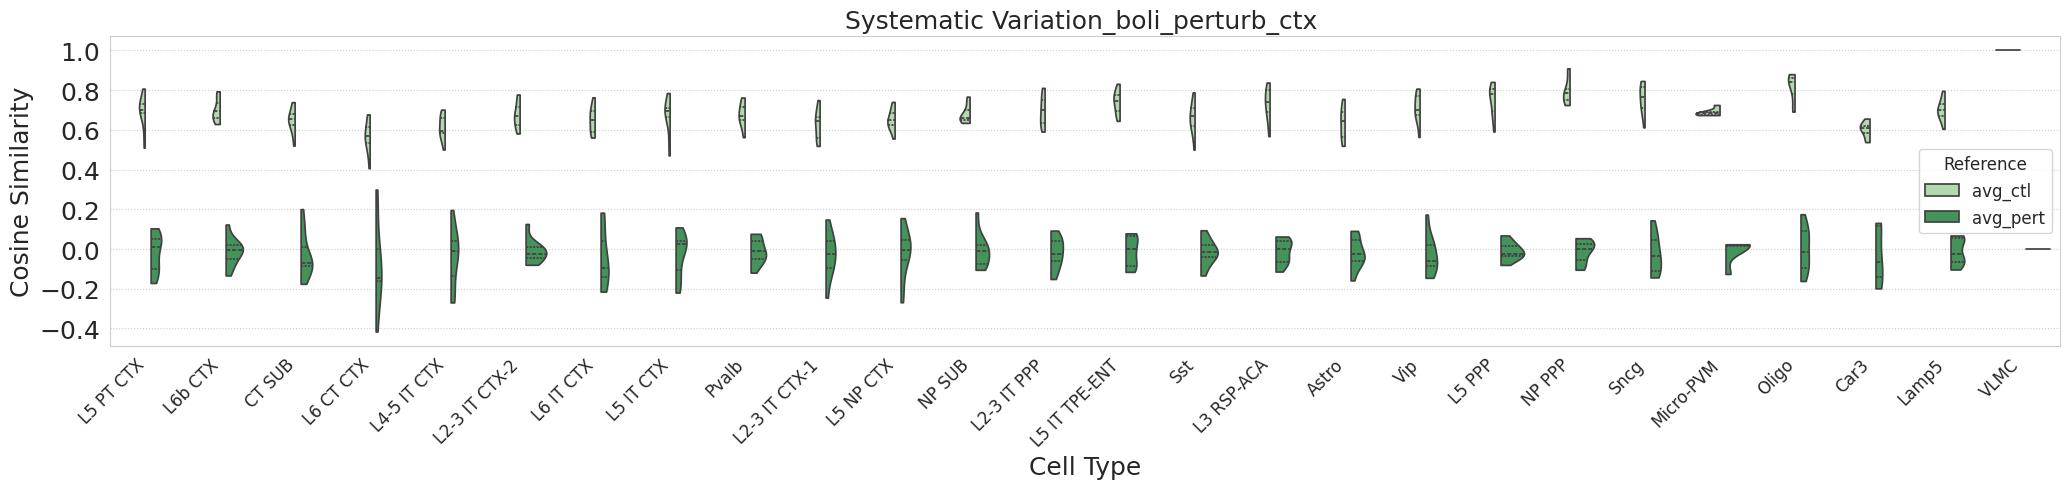

In [ ]:
# Collect data from all celltypes
all_dfs = []

for i in list(boli_perturb_ctx.obs['predicted.subclass'].unique()):
    dataset_name = f'boli_perturb_ctx_edit_ntsubset_hvg_{i}'
    try:
        temp = boli_perturb_ctx[boli_perturb_ctx.obs['predicted.subclass'] == i]
        df, df_pair, df_norm, pert_names = pre_process(temp, dataset_name)
        
        # Add celltype column
        df = df.copy()
        df['celltype'] = i
        all_dfs.append(df)
        
    except ValueError as e:
        print(f"⚠️ Skipping {i} ({dataset_name}): {e}")
        continue

# Combine all dataframes
combined_df = pd.concat(all_dfs, ignore_index=True)

# Create single plot with all celltypes
import os
output_dir = 'plots'
os.makedirs(output_dir, exist_ok=True)

save_path = os.path.join(output_dir, 'systematic_variation_all_celltypes_boli_perturb_ctx.png')

plot_systematic_variation_all(
    combined_df, 
    x_col='celltype',
    title='Systematic Variation_boli_perturb_ctx ',
    plot_type='violin',
    save_path=save_path
)


# boli_morphology_raw

In [9]:
boli_morphology = sc.read_h5ad("/gpfs/home/asun/jin_lab/database/boli_morphology/raw/adata.h5ad")

In [10]:
boli_morphology.obs['predicted.subclass'].nunique()
celltype = list(boli_morphology.obs['predicted.subclass'].unique())

⚠️ Skipping L3 RSP-ACA (boli_morphology_L3 RSP-ACA): No control cells found in dataset 'boli_morphology_L3 RSP-ACA'. Cannot compute systematic variation.
⚠️ Skipping L2/3 IT CTX-1 (boli_morphology_L2/3 IT CTX-1): No control cells found in dataset 'boli_morphology_L2/3 IT CTX-1'. Cannot compute systematic variation.
⚠️ Skipping L2/3 IT CTX-2 (boli_morphology_L2/3 IT CTX-2): No control cells found in dataset 'boli_morphology_L2/3 IT CTX-2'. Cannot compute systematic variation.
⚠️ Skipping L3 IT ENT (boli_morphology_L3 IT ENT): No control cells found in dataset 'boli_morphology_L3 IT ENT'. Cannot compute systematic variation.
⚠️ Skipping Car3 (boli_morphology_Car3): No control cells found in dataset 'boli_morphology_Car3'. Cannot compute systematic variation.
⚠️ Skipping Endo (boli_morphology_Endo): No control cells found in dataset 'boli_morphology_Endo'. Cannot compute systematic variation.
⚠️ Skipping Oligo (boli_morphology_Oligo): No control cells found in dataset 'boli_morphology_Oli

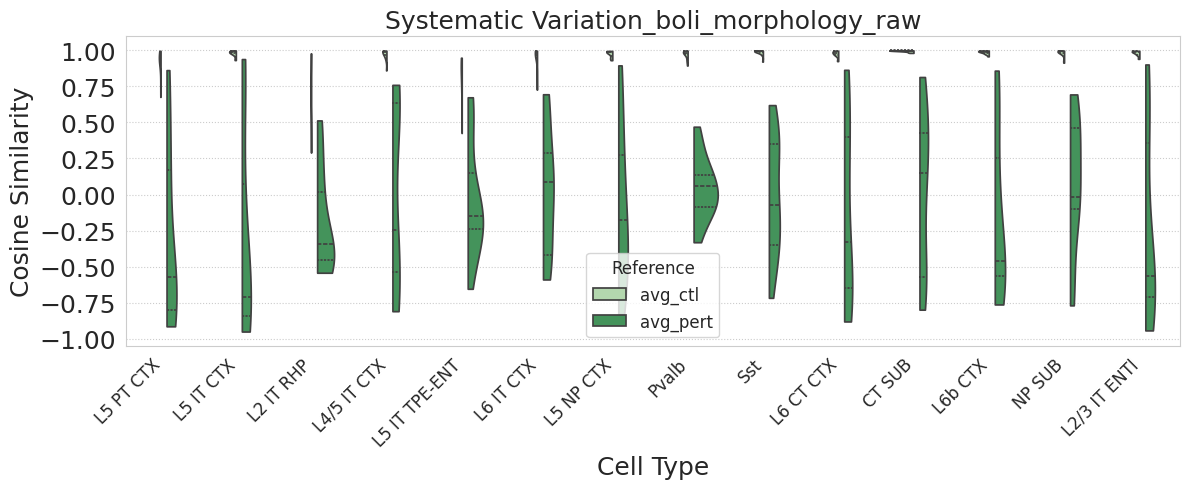

In [ ]:
# Collect data from all celltypes
all_dfs = []

for i in list(boli_morphology.obs['predicted.subclass'].unique()):
    dataset_name = f'boli_morphology_{i}'
    try:
        temp = boli_morphology[boli_morphology.obs['predicted.subclass'] == i]
        df, df_pair, df_norm, pert_names = pre_process(temp, dataset_name)
        
        # Add celltype column
        df = df.copy()
        df['celltype'] = i
        all_dfs.append(df)
        
    except ValueError as e:
        print(f"⚠️ Skipping {i} ({dataset_name}): {e}")
        continue

# Combine all dataframes
combined_df = pd.concat(all_dfs, ignore_index=True)

# Create single plot with all celltypes
import os
output_dir = 'plots'
os.makedirs(output_dir, exist_ok=True)

save_path = os.path.join(output_dir, 'systematic_variation_all_celltypes_boli_morphology_raw.png')

plot_systematic_variation_all(
    combined_df, 
    x_col='celltype',
    title='Systematic Variation_boli_morphology_raw',
    plot_type='violin',  
    save_path=save_path
)


# boli_morphology_processed

In [12]:
boli_morphology_processed = sc.read_h5ad("/gpfs/home/asun/jin_lab/database/boli_morphology/processed/gloria/adata.h5ad")

⚠️ Skipping L3 RSP-ACA (boli_morphology_processed_L3 RSP-ACA): No control cells found in dataset 'boli_morphology_processed_L3 RSP-ACA'. Cannot compute systematic variation.
⚠️ Skipping L2/3 IT CTX-1 (boli_morphology_processed_L2/3 IT CTX-1): No control cells found in dataset 'boli_morphology_processed_L2/3 IT CTX-1'. Cannot compute systematic variation.
⚠️ Skipping L2/3 IT CTX-2 (boli_morphology_processed_L2/3 IT CTX-2): No control cells found in dataset 'boli_morphology_processed_L2/3 IT CTX-2'. Cannot compute systematic variation.
⚠️ Skipping L3 IT ENT (boli_morphology_processed_L3 IT ENT): No control cells found in dataset 'boli_morphology_processed_L3 IT ENT'. Cannot compute systematic variation.
⚠️ Skipping Car3 (boli_morphology_processed_Car3): No control cells found in dataset 'boli_morphology_processed_Car3'. Cannot compute systematic variation.
⚠️ Skipping Endo (boli_morphology_processed_Endo): No control cells found in dataset 'boli_morphology_processed_Endo'. Cannot compute

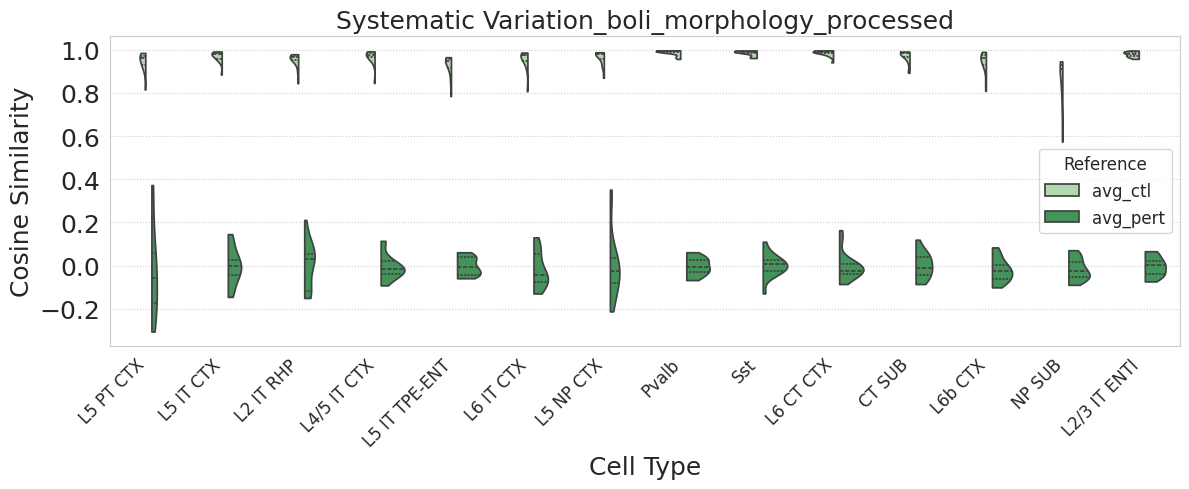

In [ ]:
# Collect data from all celltypes
all_dfs = []

for i in list(boli_morphology_processed.obs['predicted.subclass'].unique()):
    dataset_name = f'boli_morphology_processed_{i}'
    try:
        temp = boli_morphology_processed[boli_morphology_processed.obs['predicted.subclass'] == i]
        df, df_pair, df_norm, pert_names = pre_process(temp, dataset_name)
        
        # Add celltype column
        df = df.copy()
        df['celltype'] = i
        all_dfs.append(df)
        
    except ValueError as e:
        print(f"⚠️ Skipping {i} ({dataset_name}): {e}")
        continue

# Combine all dataframes
combined_df = pd.concat(all_dfs, ignore_index=True)

# Create single plot with all celltypes
import os
output_dir = 'plots'
os.makedirs(output_dir, exist_ok=True)

save_path = os.path.join(output_dir, 'systematic_variation_all_celltypes_boli_morphology_processed.png')

plot_systematic_variation_all(
    combined_df, 
    x_col='celltype',
    title='Systematic Variation_boli_morphology_processed',
    plot_type='violin', 
    save_path=save_path
)


## replogle

In [17]:
replogle = sc.read_h5ad("/gpfs/home/asun/jin_lab/database/replogle/processed/shared_pert/adata.h5ad")

In [19]:
replogle.obs

,gem_group,gene,gene_id,transcript,gene_transcript,sgID_AB,mitopercent,UMI_count,z_gemgroup_UMI,cell_line
cell_barcode,,,,,,,,,,
AAACCCAAGAATAGTC-3,3,KIAA1143,ENSG00000163807,P1P2,4360_KIAA1143_P1P2_ENSG00000163807,KIAA1143_+_44803075.23-P1P2|KIAA1143_+_4480308...,0.114029,11234.0,-0.611091,hepg2
AAACCCAAGAGGTATT-55,55,SEPHS2,ENSG00000179918,P1P2,7779_SEPHS2_P1P2_ENSG00000179918,SEPHS2_-_30457178.23-P1P2|SEPHS2_+_30457164.23...,0.165242,45146.0,0.208833,hepg2
AAACCCAAGATGGCAC-43,43,TFAM,ENSG00000108064,P1P2,8832_TFAM_P1P2_ENSG00000108064,TFAM_+_60145205.23-P1P2|TFAM_-_60145223.23-P1P2,0.071596,23912.0,2.079665,hepg2
AAACCCAAGCACACAG-14,14,BAP1,ENSG00000163930,P1P2,760_BAP1_P1P2_ENSG00000163930,BAP1_+_52443980.23-P1P2|BAP1_+_52443883.23-P1P2,0.150652,33209.0,0.083693,hepg2
AAACCCAAGCGCCATC-14,14,UXT,ENSG00000126756,P1P2,9691_UXT_P1P2_ENSG00000126756,UXT_+_47518485.23-P1P2|UXT_-_47518537.23-P1P2,0.105686,24743.0,-0.496336,hepg2
...,...,...,...,...,...,...,...,...,...,...
TTTGTTGTCTATCGTT-35,35,MANF,ENSG00000145050,P1P2,4795_MANF_P1P2_ENSG00000145050,MANF_-_51422730.23-P1P2|MANF_-_51422736.23-P1P2,0.060327,11305.0,1.141917,rpe1
TTTGTTGTCTCGAGTA-55,55,CSTF1,ENSG00000101138,P1P2,1915_CSTF1_P1P2_ENSG00000101138,CSTF1_+_54967480.23-P1P2|CSTF1_-_54967707.23-P1P2,0.046033,16358.0,0.616750,rpe1
TTTGTTGTCTGATGGT-14,14,SLC1A5,ENSG00000105281,P1,7976_SLC1A5_P1_ENSG00000105281,SLC1A5_+_47291839.23-P1|SLC1A5_+_47291829.23-P1,0.062634,15423.0,0.347911,rpe1


In [26]:
replogle[replogle.obs['gene'] == 'non-targeting']

View of AnnData object with n_obs × n_vars = 39165 × 6642
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'cell_line'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'X_hvg'

In [27]:
replogle.obs['Assign'] = replogle.obs['gene']


In [32]:
replogle.obs['cell_line'].value_counts()

cell_line
jurkat    97980
k562      94316
rpe1      87524
hepg2     50439
Name: count, dtype: int64

In [29]:
replogle.obs['Assign'] = replogle.obs['Assign'].astype(str)
replogle.obs['Assign'] = replogle.obs['Assign'].str.replace('non-targeting', 'NT_0')


/tmp/ipykernel_22586/883145639.py:26: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


Saved plot to: plots/systematic_variation_all_celltypes_replogle.png


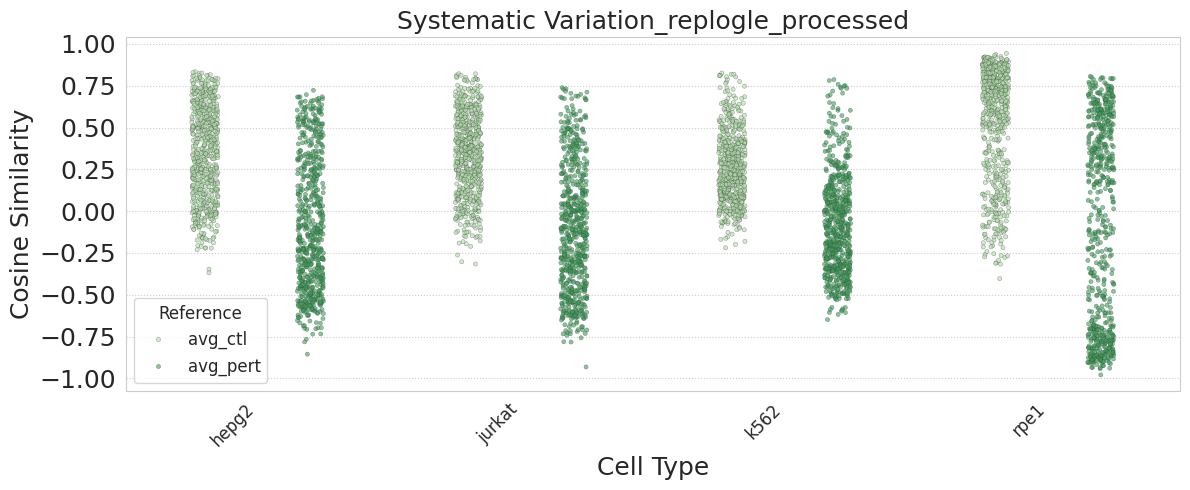

In [33]:
# Collect data from all celltypes
all_dfs = []

for i in list(replogle.obs['cell_line'].unique()):
    dataset_name = f'replogle_{i}'
    try:
        temp = replogle[replogle.obs['cell_line'] == i]
        df, df_pair, df_norm, pert_names = pre_process(temp, dataset_name)
        
        # Add celltype column
        df = df.copy()
        df['celltype'] = i
        all_dfs.append(df)
        
    except ValueError as e:
        print(f"⚠️ Skipping {i} ({dataset_name}): {e}")
        continue

# Combine all dataframes
combined_df = pd.concat(all_dfs, ignore_index=True)

# Create single plot with all celltypes
import os
output_dir = 'plots'
os.makedirs(output_dir, exist_ok=True)

save_path = os.path.join(output_dir, 'systematic_variation_all_celltypes_replogle.png')

plot_systematic_variation_all(
    combined_df, 
    x_col='celltype',
    title='Systematic Variation_replogle_processed',
    plot_type='points', 
    save_path=save_path
)
